### Load the Lending Club dataset  
1. Load the dataset into a data frame named loans. Using SFrame, this would look like

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

def quick_analysis(df):
    print("Data Types:")
    print(df.dtypes)
    print("Rows and Columns:")
    print(df.shape)
    print("Column Names:")
    print(df.columns)
    print("Null Values:")
    print(df.apply(lambda x: sum(x.isnull()) / len(df)));

In [2]:
loans = pd.read_csv('lending-club-data.csv')


/Users/llchen5/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(loans.shape)

(122607, 68)


### Exploring some features
2. Let's quickly explore what the dataset looks like. First, print out the column names to see what features we have in this dataset. On SFrame, you can run this code:

Exploring the target column
The target column (label column) of the dataset that we are interested in is called bad_loans. In this column 1 means a risky (bad) loan 0 means a safe loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:

* +1 as a safe loan
* -1 as a risky (bad) loan

In [4]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x: +1 if x==0 else -1)
loans = loans.drop(columns=['bad_loans'])

In [5]:
loans['safe_loans'].value_counts()
print(99457/(99457+23150))

0.8111853319957262


In [6]:
print(len(loans[loans['safe_loans']==1])/len(loans))
print(len(loans[loans['safe_loans']==-1])/len(loans))

0.8111853319957262
0.18881466800427382


In [7]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

In [8]:
loans['purpose'].value_counts()

debt_consolidation    68233
credit_card           22050
other                  9087
home_improvement       7543
major_purchase         3877
small_business         3264
car                    2375
medical                1607
wedding                1526
moving                 1180
house                  1005
vacation                860
Name: purpose, dtype: int64

In [9]:
loans.head(2)

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.0,1
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,-1


In [10]:
categorical_variables = []
for i, j in zip(loans.dtypes,loans.columns):
    if (i == object):
        categorical_variables.append(j)


In [11]:
categorical_variables
#loan = loans.copy()

['grade', 'sub_grade', 'home_ownership', 'purpose', 'term']

In [12]:
for feature in categorical_variables:
    coded_feature = pd.get_dummies(loans[feature],prefix=feature)
    loans = loans.drop(columns=[feature],axis=1)
    loans = pd.concat([loans,coded_feature], axis=1)

In [13]:
train_idx = pd.read_json('train-idx.json')
test_idx = pd.read_json('validation-idx.json')
train_data = loans.iloc[train_idx[0]]
test_data = loans.iloc[test_idx[0]]

In [14]:
loans.head(2)

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0,11,27.65,1,1,83.7,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1.00,1,1,9.4,0.0,-1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
train_data_X = train_data.drop('safe_loans',axis=1).values
train_data_y = train_data['safe_loans'].values
print(train_data_X.shape)
print(train_data_y.shape)

(37224, 67)
(37224,)


In [16]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth=6)
dt_clf.fit(train_data_X,train_data_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
small_model = DecisionTreeClassifier(max_depth=2)
small_model.fit(train_data_X,train_data_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

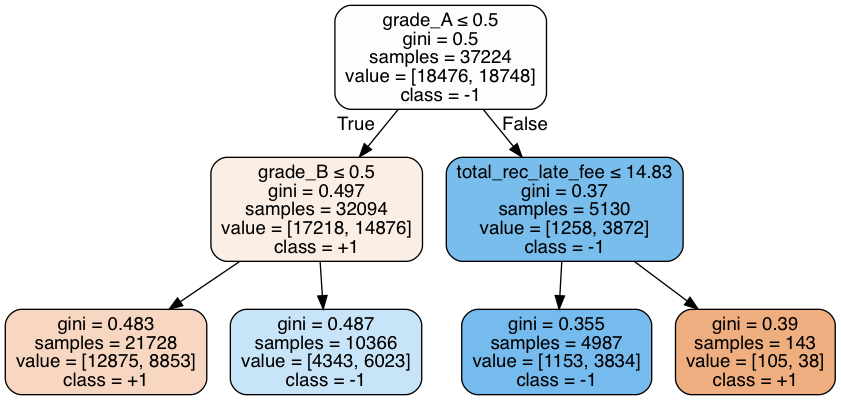

In [21]:

from sklearn import tree
import graphviz 
from os import system

dot_data = tree.export_graphviz(small_model, out_file='simple_tree.dot',
                               feature_names=train_data.drop('safe_loans',axis=1).columns,  
                         class_names=['+1','-1'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
system("dot -Tpng simple_tree.dot -o simple_tree.png")

from IPython.display import Image
Image(filename='simple_tree.png')

In [23]:
validation_safe_loans = test_data[test_data[target] == 1]
validation_risky_loans = test_data[test_data[target] == -1]

In [24]:
sample_validation_safe_loans =  validation_safe_loans.iloc[0:2]
sample_validation_risky_loans =  validation_risky_loans.iloc[0:2]

In [25]:
sample_validation_loans = sample_validation_safe_loans.append(sample_validation_risky_loans)

In [28]:
sample_validation_loans[target]

19    1
79    1
24   -1
41   -1
Name: safe_loans, dtype: int64

In [42]:
dt_clf.predict(sample_validation_loans.drop(target,axis=1).values)

In [30]:
dt_clf.predict_proba(sample_validation_loans.drop(target,axis=1).values)

array([[0.34156543, 0.65843457],
       [0.53630646, 0.46369354],
       [0.64750958, 0.35249042],
       [0.20789474, 0.79210526]])

In [31]:
small_model.predict_proba(sample_validation_loans.drop(target,axis=1).values)

array([[0.41896585, 0.58103415],
       [0.59255339, 0.40744661],
       [0.59255339, 0.40744661],
       [0.23120112, 0.76879888]])

In [32]:
small_model.predict(sample_validation_loans.drop(target,axis=1).values)

array([ 1, -1, -1,  1])

In [38]:
test_data_X = test_data.drop('safe_loans',axis=1).values
test_data_y = test_data['safe_loans'].values

#small_model.predict(test_data_X)

In [39]:
small_model.score(test_data_X,test_data_y)

0.6193451098664369

In [40]:
dt_clf.score(test_data_X,test_data_y)

0.6361482119775959

In [41]:
big_model = DecisionTreeClassifier(max_depth=10)
big_model.fit(train_data_X,train_data_y)
big_model.score(test_data_X,test_data_y)

0.6263464024127531

In [44]:
predictions = dt_clf.predict(test_data_X)

from sklearn.metrics import confusion_matrix
confusion_matrix(test_data_y, predictions)

array([[3013, 1661],
       [1717, 2893]])